In [323]:
import pandas as pd
import numpy as np
import dtale
from scipy import stats
import random
from sklearn import preprocessing 
import matplotlib.pyplot as plt

* Separate test set
* remove nan values
* separate val set
* replace remaining nan values
* reshape
* Augment
* scale with MinMaxScaler

In [2]:
Input0 = pd.read_csv('Data/Input.csv')
Input0.head(n=2)

,A3,Year,Control of Corruption: Estimate,Control of Corruption: Standard Error,Government Effectiveness: Estimate,Government Effectiveness: Standard Error,Political Stability and Absence of Violence/Terrorism: Estimate,Political Stability and Absence of Violence/Terrorism: Standard Error,Regulatory Quality: Estimate,Regulatory Quality: Standard Error,Rule of Law: Estimate,Rule of Law: Standard Error,Voice and Accountability: Estimate,Voice and Accountability: Standard Error,Temperature change,HDI,Population,Refugees
0,ABW,1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.875,NaN,NaN,NaN
1,ABW,1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.551,NaN,NaN,NaN


# Separate test set

We'll use time windows of length 6, and shift it one year forward to create new samples

<div class="girk">
* For the test countries we exclude only the last period completely
</div><i class="fa fa-lightbulb-o "></i>

In [3]:
Test_country_list = ['IRQ', 'SYR', 'LBY', 'LBN','JOR', 'SAU', 'TUN', 'THA', 'UKR']
Test_mask_country = Input0['A3'].isin(Test_country_list)
Test_mask_year = Input0['Year']>=2015
Test_mask = Test_mask_country & Test_mask_year
Test = Input0[Test_mask]
Train_val = Input0[~Test_mask]
#we are ony interested in the last period 2017-2020
Test = Test[Test['Year']<2021]
Test.head(2)

,A3,Year,Control of Corruption: Estimate,Control of Corruption: Standard Error,Government Effectiveness: Estimate,Government Effectiveness: Standard Error,Political Stability and Absence of Violence/Terrorism: Estimate,Political Stability and Absence of Violence/Terrorism: Standard Error,Regulatory Quality: Estimate,Regulatory Quality: Standard Error,Rule of Law: Estimate,Rule of Law: Standard Error,Voice and Accountability: Estimate,Voice and Accountability: Standard Error,Temperature change,HDI,Population,Refugees
2203,IRQ,2015,-1.368879,0.156260,-1.246434,0.218023,-2.260352,0.210538,-1.237460,0.204665,-1.417770,0.180222,-1.127942,0.135802,1.866,0.649,35572261.0,264086.0
2204,IRQ,2016,-1.386965,0.161193,-1.267530,0.208636,-2.313588,0.216167,-1.125068,0.209853,-1.625595,0.183479,-1.015599,0.131402,1.621,0.656,36610632.0,316056.0


# Remove/Replace nans, separate validation set

In [4]:
#Let us first create a lsit for the 20 time periods of length 6 and corresponding prediction years
Periods = []
num_periods = 20#starting from 96 and shifting until 2015
len_input = 5
len_time_window = 6
for i in range(num_periods):
    Periods.append(list(range(1996+i,2002+i)))
Predict_year = list(range(2001,2021))

## Remove whole period for a country if target year is missing 

In [5]:
#lets remove the whole period for a country, if refugee number is not given for the end of the period(prediction year)
#first we create a list and separate the periods
Input_periods0 = []
for i in range(num_periods):
    #separate into 8 time windows
    Input_periods0.append(Train_val[Train_val['Year'].isin(Periods[i])])

In [6]:
Input_periods1 = []
for i in range(num_periods):
    period = Input_periods0[i]
    predict_mask = period['Year'] == Predict_year[i]#mask prediciton years
    predict_years = period[predict_mask] #select prediction years
    missing_pred_mask = predict_years['Refugees'].isnull() #mask nan vals
    missing_countries_list = predict_years[missing_pred_mask]['A3']#countries with nans
    nan_countries_mask = period['A3'].isin(missing_countries_list)#mask nan countries
    period_clean = period[~nan_countries_mask]#drop these countries
    Input_periods1.append(period_clean)

## Remove nans if nan count above threshold

There are 10 features and the input period has a length of 5 \
* this means half the entries is 25, let's set this as a threshold\
    if the overall nan count for a country exceeds 25 let's exclude this period for this country
* else we use the mean over the present entries, if one feature has no entries at all,\
    lets replace it by the overall mean of this period

### Separate std
    we separate the std columns to use the later for augmentation, for now they are not important
    to not apply all the operations to the std columns, we do an inner merge at the end

In [7]:
Std_periods = []
Input_periods2 = []
std_columns = [c for c in Input_periods1[0].columns if c[-5:]=='Error']
for i in range(num_periods):
    columns = ['A3', 'Year']+std_columns
    Std_periods.append(Input_periods1[i][columns])
    Input_periods2.append(Input_periods1[i].drop(columns = std_columns))

### Remove nans

In [8]:
Input_periods3 = []
for i in range(num_periods):
    # except ref_num no other features are needed in the target year 
    # so before counting nans, lets exclude it
    target_mask = Input_periods2[i]['Year'] == Predict_year[i]#mask 2020
    Input_no_target = Input_periods2[i][~target_mask]#exclude 2020
    
    nan_count_df = Input_no_target.drop('A3', 1).isna().groupby(Input_no_target.A3, sort=False).sum().reset_index()
    nan_count_total = nan_count_df.sum(axis = 1)
    nan_count_mask = nan_count_total<=int((10*len_input)/2)#total nan countr threshold
    #we include only these countries, so now let's apply the mask
    include_countries = nan_count_df[nan_count_mask]
    include_countries_mask = Input_periods2[i].A3.isin(include_countries['A3'])
    Input_periods3.append(Input_periods2[i][include_countries_mask])

## Remove country if a column has only nans for a country in a period

In [9]:
Input_periods4 = []
for i in range(num_periods):
    #again lets first exclude targets
    target_mask = Input_periods3[i]['Year']==Predict_year[i]
    Input_no_target = Input_periods3[i][~target_mask]#exclude target years
    
    nan_count_df = Input_no_target.drop('A3', 1).isna().groupby(Input_no_target.A3, sort=False).sum().reset_index()
    nan_count_mask = nan_count_df.iloc[:,2:] == len_input #mask where all 5 input years are nan
    delete_rows_mask = nan_count_mask.any(axis=1)
    delete_rows = nan_count_df[delete_rows_mask]
    exclude_countries = delete_rows.A3.unique()
    exclude_countries_mask = Input_periods3[i].A3.isin(exclude_countries)
    Input_periods4.append(Input_periods3[i][~exclude_countries_mask])

## Validation set

Since the validation set should resemble real world data, we separate it before replacing any nan values

In [133]:
Validation_periods = []
Train_periods = []
#to avoid intersections between the train and validation set we have to exclude the chosen countries for the next five years
Validation_countries = list(range(num_periods))
for i in range(num_periods):
    Validation_countries[i] = []

for i in range(num_periods):
    #again lets first exclude targets
    target_mask = Input_periods4[i]['Year']==Predict_year[i]
    Input_no_target = Input_periods4[i][~target_mask]
    #Lets separate countries that have nan entries
    nan_count_df = Input_no_target.drop('A3', 1).isna().groupby(Input_no_target.A3, sort=False).sum().reset_index()
    nan_count_total = nan_count_df.sum(axis = 1)#sum over columns
    no_nan_mask = nan_count_total == 0 #no nans mask
    no_nan_countries = nan_count_df[no_nan_mask]#we include only these countries, so now let's apply the mask
    Country_list = no_nan_countries.A3.unique()
    #We take 10 percent for validation
    random.seed(version=2)
    val_countries = random.sample(
        list(Country_list), int(len(Country_list)/10))
    validation_mask0 = Input_periods4[i].A3.isin(val_countries)
    val = Input_periods4[i][validation_mask0]
    #remove if not all years are present
    country_counts = val.pivot_table(index=['A3'], aggfunc='size')
    country_counts_mask = country_counts < len_time_window
    exclude_countries = country_counts.index[np.where(country_counts_mask)]
    exclude_countries_mask = val.A3.isin(exclude_countries)
    val = val[~exclude_countries_mask]
    #Sort by vountry and year before storing it
    val = val.sort_values(['A3', 'Year'], ascending=[True, True])
    #exclude validation countries for the next 5 years, such that they 
    #cannot not be used for prediciton of next time periods
    if i<16:
        for j in range(len_input):
            Validation_countries[j+i] += val_countries 
    validation_mask1 = Input_periods4[i].A3.isin(Validation_countries[i])
    train = Input_periods4[i][~(validation_mask0 & validation_mask1)] #exclude here countries from previous years
    
    
    
    Train_periods.append(train)
    Validation_periods.append(val)

## Replace all remaining nan values with the mean over the country (within one period)

In [126]:
Train_periods1 = []
for i in range(num_periods):
    #Lets exclude the last target 
    target_mask = Train_periods[i]['Year']==Predict_year[i]
    Input_no_target = Train_periods[i][~target_mask]
    Input_target = Train_periods[i][target_mask]
    #select feature columns
    feat_columns = Input_no_target.columns[2:]
    #Replace missing  values with mean
    feat_input = Input_no_target[feat_columns]
    Input_no_target.loc[:,feat_columns] = feat_input.fillna(
        Input_no_target.groupby('A3')[feat_columns].transform('mean'))
    Input = pd.concat([Input_no_target, Input_target])
    Train_periods1.append(Input)

D:\Programme\Anaconda\envs\tfCPU\lib\site-packages\pandas\core\indexing.py:1717: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\Programme\Anaconda\envs\tfCPU\lib\site-packages\pandas\core\indexing.py:1717: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\Programme\Anaconda\envs\tfCPU\lib\site-packages\pandas\core\indexing.py:1717: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

There are by now no nan values, except in 2020

# Reshape 
    [n_samples, timesteps, features]
    samples is always one country for a 5 year period

## Merge with Std 

In [127]:
print(len(Train_periods1[0].columns)-2)
#Therre are 10 features
Train_periods[0].columns

10


Index(['A3', 'Year', 'Control of Corruption: Estimate',
       'Government Effectiveness: Estimate',
       'Political Stability and Absence of Violence/Terrorism: Estimate',
       'Regulatory Quality: Estimate', 'Rule of Law: Estimate',
       'Voice and Accountability: Estimate', 'Temperature change', 'HDI',
       'Population', 'Refugees'],
      dtype='object')

In [211]:
Train_periods2[0].head(10)

,A3,Year,Control of Corruption: Estimate,Government Effectiveness: Estimate,Political Stability and Absence of Violence/Terrorism: Estimate,Regulatory Quality: Estimate,Rule of Law: Estimate,Voice and Accountability: Estimate,Temperature change,HDI,Population,Refugees
0,AFG,1996,-1.291705,-2.175167,-2.414042,-2.090330,-1.788075,-1.908540,-0.106,0.3350,18853437.0,2674234.0
1,AFG,1997,-1.236276,-2.155555,-2.418519,-2.088793,-1.762608,-1.973920,0.480,0.3390,19357126.0,2676675.0
2,AFG,1998,-1.180848,-2.135942,-2.422996,-2.087256,-1.737140,-2.039301,0.669,0.3440,19737765.0,2667118.0
3,AFG,1999,-1.238114,-2.183797,-2.431592,-2.098441,-1.757788,-2.035359,1.178,0.3480,20170844.0,2601690.0
4,AFG,2000,-1.295380,-2.231651,-2.440187,-2.109626,-1.778437,-2.031417,0.996,0.3500,20779953.0,3587327.0
5,AGO,1996,-1.167702,-0.859940,-2.057286,-1.415345,-1.630469,-1.578164,0.436,0.3955,14400719.0,249686.0
6,AGO,1997,-1.286769,-1.100861,-2.185179,-1.552502,-1.665611,-1.495022,0.291,0.3955,14871570.0,267687.0
7,AGO,1998,-1.405836,-1.341783,-2.313072,-1.689659,-1.700753,-1.411879,1.199,0.3955,15359601.0,319420.0
8,AGO,1999,-1.464260,-1.402046,-2.174328,-1.744495,-1.682030,-1.434972,0.443,0.3910,15866869.0,353472.0
9,AGO,2000,-1.522685,-1.462310,-2.035583,-1.799331,-1.663307,-1.458065,0.204,0.4000,16395473.0,433756.0


In [210]:
Std_periods1[0].head(10)

,A3,Year,Control of Corruption: Standard Error,Government Effectiveness: Standard Error,Political Stability and Absence of Violence/Terrorism: Standard Error,Regulatory Quality: Standard Error,Rule of Law: Standard Error,Voice and Accountability: Standard Error
0,AFG,1996,0.340507,0.187618,0.475315,0.386360,0.350509,0.261457
1,AFG,1997,0.335343,0.248948,0.455319,0.418879,0.341040,0.258773
2,AFG,1998,0.330179,0.310279,0.435324,0.451397,0.331571,0.256090
3,AFG,1999,0.343237,0.326673,0.445483,0.439005,0.312794,0.255066
4,AFG,2000,0.356294,0.343066,0.455642,0.426612,0.294017,0.254043
5,AGO,1996,0.262077,0.173904,0.373857,0.311747,0.212429,0.208810
6,AGO,1997,0.236903,0.188529,0.359660,0.290505,0.211164,0.211628
7,AGO,1998,0.211729,0.203155,0.345463,0.269265,0.209898,0.214446
8,AGO,1999,0.215868,0.207196,0.344136,0.265624,0.196339,0.205865
9,AGO,2000,0.220008,0.211237,0.342809,0.261984,0.182780,0.197283


In [219]:
list(exclude_countries)

['FSM', 'KIR', 'PLW']

In [282]:
Std_periods_f = []
Train_periods_f = []
for i in range(num_periods):
    #inner merge
    std_period = Train_periods1[i].merge(Std_periods[i], how = 'inner')
    std_period = std_period.sort_values(['A3', 'Year'], ascending=[True, True])#sort
    
    target_mask = std_period.Year == Predict_year[i]
    std_period_no_target = std_period[~target_mask]
    
    #Exclude countries where all the stds are nan
    nan_count_df = std_period_no_target.drop('A3', 1).isna().groupby(std_period_no_target.A3, sort=False).sum().reset_index()
    nan_count_mask = nan_count_df.iloc[:,2:] == len_input #mask where all 5 input years are nan
    delete_rows_mask = nan_count_mask.any(axis=1)
    delete_rows = nan_count_df[delete_rows_mask]
    exclude_countries = delete_rows.A3.unique()
    exclude_countries_mask = std_period.A3.isin(exclude_countries)
    std_period = std_period[~exclude_countries_mask]
    
    #the rest we replace with mean
    target_mask = std_period.Year == Predict_year[i]
    std_period_no_target = std_period[~target_mask]
    std_period_target = std_period[target_mask]
    #select feature columns
    feat_columns = std_period_no_target.columns[2:]
    #Replace missing  values with mean
    feat_input = std_period_no_target[feat_columns]
    std_period_no_target.loc[:,feat_columns] = feat_input.fillna(
        std_period_no_target.groupby('A3')[feat_columns].transform('mean'))
    std_period = pd.concat([std_period_no_target, std_period_target])
    #remove if not all 6 entries are present for a country
    country_counts = std_period.pivot_table(index=['A3'], aggfunc='size')
    country_counts_mask = country_counts < len_time_window
    exclude_countries = country_counts.index[np.where(country_counts_mask)]
    exclude_countries_mask = std_period.A3.isin(list(exclude_countries))
    std_period = std_period[~exclude_countries_mask]
    #sort before storing
    std_period = std_period.sort_values(['A3', 'Year'], ascending=[True, True])#sort
    
    Train_periods_f.append(std_period.iloc[:,:12])#split up again
    Std_periods_f.append(std_period.iloc[:,list(range(2))+list(range(12,len(std_period.columns)))]) 
    #now the df are in the same order

D:\Programme\Anaconda\envs\tfCPU\lib\site-packages\pandas\core\indexing.py:1717: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\Programme\Anaconda\envs\tfCPU\lib\site-packages\pandas\core\indexing.py:1717: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\Programme\Anaconda\envs\tfCPU\lib\site-packages\pandas\core\indexing.py:1717: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

## Reshape and augment

### Reshape train set and augment

In [176]:
dtale.show(train_periods)

In [205]:
std_all.shape

(172, 6, 8, 10)

In [203]:
    np.count_nonzero(std_all[:,:-1,2:8,:]>0)

D:\Programme\Anaconda\envs\tfCPU\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in greater



43020

In [297]:
Train_reshaped_list = []
num_augmentations = 10
for i in range(num_periods):
    std_periods = Std_periods_f[i]
    train_periods = Train_periods_f[i]
    
    num_samples = int(len(std_periods)/len_time_window)
    timesteps = len_time_window
    features_std = len(std_periods.columns)
    features_train = len(train_periods.columns)
    
    #reshape array into tf ready form
    std_reshaped = np.array(std_periods).reshape((num_samples, timesteps,features_std),  order = 'C')
    train_reshaped = np.array(train_periods).reshape((num_samples, timesteps,features_train), order = 'C' )
    #copy along last dimension: new_shape = [n_samples, timesteps, n_feat, num_aug]
    std_all = np.repeat(std_reshaped[:, :, :,np.newaxis], num_augmentations, axis=3)
    train_all = np.repeat(train_reshaped[:, :, :,np.newaxis], num_augmentations, axis=3)
    #we only augment features, where std is given
    train_all[:,:-1,2:8,:] = stats.norm.rvs(
        loc = train_all[:,:-1,2:8,:].astype(dtype=float), scale = std_all[:,:-1,2:8,:].astype(dtype= float)) 
    split_train_all = np.split(train_all, 10,  axis = -1)
    train_all = np.concatenate(split_train_all, axis = 0)
    Train_reshaped_list.append(train_all)

In [302]:
Train_all = np.concatenate(Train_reshaped_list, axis = 0)

In [303]:
#all samples, up until last year, all feats except year andcountry
X_train = Train_all[:,:-1,2:,0]#last dimension is singleton
Y_train = Train_all[:,-1,-1,0]#all samples, last year, last feature(ref_num)

### Reshape val and test set 

### Val 

In [305]:
Val_list = []
for i in range(num_periods):
    val = Validation_periods[i]
    num_samples = int(len(val)/len_time_window)
    timesteps = len_time_window
    features_val = len(val.columns)
    #reshape
    val_reshaped = np.array(val).reshape((num_samples, timesteps, features_val))
    Val_list.append(val_reshaped)
#convert list to array
Val_all = np.concatenate(Val_list, axis = 0)

Separate val in input and output 

In [306]:
X_val = Val_all[:,:-1,2:]#also drop the year and country 'feature'
Y_val = Val_all[:,-1,-1]#the length of Yval is the number of samples, 
#one has maybe to expand it for training

### Test 

In [308]:
#we have to drop Error columns
std_columns = [c for c in Test.columns if c[-5:]=='Error']
Test = Test.drop(columns = std_columns)
#seems to be sorted,just to be sure sort again
Test = Test.sort_values(['A3', 'Year'], ascending=[True, True])
#Reshape
num_samples = int(len(Test)/len_time_window)
timesteps = len_time_window
features_test = len(Test.columns)
Test_all = np.array(Test).reshape((num_samples, timesteps,features_test))

Separate

In [309]:
X_test = Test_all[:,:-1,2:]#also drop the year and country 'feature'
Y_test = Test_all[:,-1,-1]#the length of Yval is the number of samples, 

# Scaling

Use robust scaler to scale inputs

In [336]:
#scale the training set and use this params to scale test and val
#we'll scale a feature across all samples and timesteps 
#thus we have to reshape to (n_samples*timesteps, features), scale
#1. Reshape
tr_shape = X_train.shape
X_train_temp = np.reshape(
    X_train,(tr_shape[0]*tr_shape[1], tr_shape[2]), order = 'F')
#test if reshaping works as expected
length = tr_shape[0]
print(X_train[0,:3,0]-X_train_temp[[0, length, 2*length],0])#yes
#test if original shape is retained
X_train_n = np.reshape(X_train_temp, X_train.shape, order = 'F')#yes
print(X_train_n[:2,:2,:2]- X_train[:2,:2,:2])
#2. Scale 
transformer = preprocessing.QuantileTransformer().fit(X_train_temp)
X_train_scaled = transformer.transform(X_train_temp)
X_train_final = np.reshape(X_train_scaled, X_train.shape, order = 'F')

[0.0 0.0 0.0]
[[[0.0 0.0]
  [0.0 0.0]]

 [[0.0 0.0]
  [0.0 0.0]]]


In [889]:
#use the same transformer to scale train and val

In [337]:
te_shape = X_test.shape
X_test_temp = np.reshape(
    X_test,(te_shape[0]*te_shape[1], te_shape[2]), order = 'F')
X_test_scaled = transformer.transform(X_test_temp)
X_test_final = np.reshape(X_test_scaled, X_test.shape, order = 'F')

va_shape = X_val.shape
X_val_temp = np.reshape(
    X_val,(va_shape[0]*va_shape[1], va_shape[2]), order = 'F')
X_val_scaled = transformer.transform(X_val_temp)
X_val_final = np.reshape(X_val_scaled, X_val.shape, order = 'F')

Here is an example of how the distribution changed

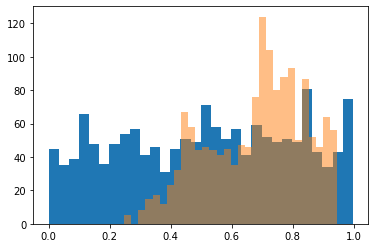

In [338]:
_ = plt.hist(X_val_scaled[:,-3],30)
_ = plt.hist(X_val_temp[:,-3],30, alpha = .5)

# Analysis

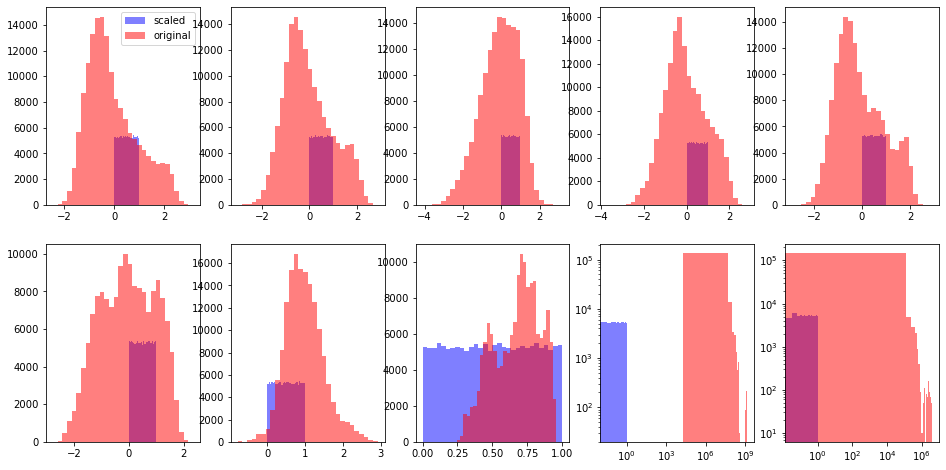

In [339]:
#Compare old and scaled data
num_feats = 10
fig, ax = plt.subplots(2,5,figsize = (16,8))
ax = ax.flatten()
for i in range(num_feats):
    ax[i].hist(X_train_scaled[:,i],30, color = 'b', alpha = .5, label = 'scaled')
    ax[i].hist(X_train_temp[:,i],30, alpha = .5, color = 'r', label = 'original')
    if i==8 or i==9:
        ax[i].set_yscale('log')
        ax[i].set_xscale('log')
ax[0].legend()

# Store data

In [340]:
Tf_ready_dict = {
    'X_train':X_train_final, 'Y_train':Y_train,
    'X_val':X_val_final, 'Y_val':Y_val,
    'X_test':X_test_final, 'Y_test':Y_test}
np.save("Data_tf_ready_QT.npy", Tf_ready_dict)
#d2=np.load("Data_tf_ready.npy", allow_pickle=True)

#d2[()]['X_train'][1,1,1]